<a href="https://colab.research.google.com/github/karencfisher/IBM-AI-Prof.-Certificate-Capstone/blob/main/models/DL0321EN_4_1_Comparing_Models_py_v1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://cognitiveclass.ai"><img src = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/Logos/organization_logo/organization_logo.png" width = 400> </a>

<h1 align=center><font size = 5>Peer Review Final Assignment</font></h1>

## Introduction


In this lab, you will build an image classifier using the VGG16 pre-trained model, and you will evaluate it and compare its performance to the model we built in the last module using the ResNet50 pre-trained model. Good luck!

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>    

1. <a href="#item41">Download Data 
2. <a href="#item42">Part 1</a>
3. <a href="#item43">Part 2</a>  
4. <a href="#item44">Part 3</a>  

</font>
    
</div>

<a id="item41"></a>

### Where I am storing trained models for quick use

On my Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

my_path = '/content/drive/MyDrive/model'

Mounted at /content/drive


## Download Data

Use the <code>wget</code> command to download the data for this assignment from here: https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/concrete_data_week4.zip

Use the following cells to download the data.

In [4]:
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/concrete_data_week4.zip

--2021-11-07 02:14:22--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/concrete_data_week4.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261483817 (249M) [application/zip]
Saving to: ‘concrete_data_week4.zip’

concrete_data_week4 100%[===================>] 249.37M  23.6MB/s    in 9.6s    

2021-11-07 02:14:32 (26.0 MB/s) - ‘concrete_data_week4.zip’ saved [261483817/261483817]



In [5]:
!unzip -q concrete_data_week4.zip

### I have a utilities module I can use a metrics function I may be able to use to compare the models.

In [6]:
!wget https://raw.githubusercontent.com/karencfisher/COVID19/main/tools/util.py

--2021-11-07 02:14:51--  https://raw.githubusercontent.com/karencfisher/COVID19/main/tools/util.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5978 (5.8K) [text/plain]
Saving to: ‘util.py’

util.py             100%[===================>]   5.84K  --.-KB/s    in 0s      

2021-11-07 02:14:51 (40.7 MB/s) - ‘util.py’ saved [5978/5978]



After you unzip the data, you fill find the data has already been divided into a train, validation, and test sets.

<a id="item42"></a>

## Part 1

In this part, you will design a classifier using the VGG16 pre-trained model. Just like the ResNet50 model, you can import the model <code>VGG16</code> from <code>keras.applications</code>.

You will essentially build your classifier as follows:
1. Import libraries, modules, and packages you will need. Make sure to import the *preprocess_input* function from <code>keras.applications.vgg16</code>.
2. Use a batch size of 100 images for both training and validation.
3. Construct an ImageDataGenerator for the training set and another one for the validation set. VGG16 was originally trained on 224 × 224 images, so make sure to address that when defining the ImageDataGenerator instances.
4. Create a sequential model using Keras. Add VGG16 model to it and dense layer.
5. Compile the mode using the adam optimizer and the categorical_crossentropy loss function.
6. Fit the model on the augmented data using the ImageDataGenerators.

Use the following cells to create your classifier.

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping

from util import model_metrics


### Build our model 

In [8]:
# Load instance of the VGG16 model 
base_model = VGG16(include_top=False, weights='imagenet')

# Freeze all layers
for layer in base_model.layers:
  layer.trainable = False

58900480/58889256 [==============================] - 1s 0us/step


In [9]:
# build our final dense layer(s) on top of it
feature_map = base_model.output
flat = GlobalAveragePooling2D()(feature_map)
output = Dense(2, activation='softmax')(flat)

model = Model(inputs=base_model.input, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [10]:
# compile our model and have it ready to roll
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Prepare image data generators

Create train, validation, and test data generators to import images into the model by batch.

(We can add data augmentation to the training generator if it seems of use.)

As for batch sizes: it is actually expeditiously to specify batches sizes as powers of 2, e.g. $32 = 2^5$. This has to do with more readily fitting the batch data to memory pages such as in the GPU. At least, I have read such.

In [11]:
batch_size = 32
target_shape =  (224, 224)
classes = ['negative', 'positive']
base_dir = 'concrete_data_week4'

image_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_path = os.path.join(base_dir, 'train')
train_data = image_generator.flow_from_directory(directory=train_path,
                                                 target_size=target_shape,
                                                 batch_size=batch_size,
                                                 shuffle=True,
                                                 class_mode='categorical',
                                                 classes=classes)

valid_path = os.path.join(base_dir, 'valid')
valid_data = image_generator.flow_from_directory(directory=valid_path,
                                                 target_size=target_shape,
                                                 batch_size=batch_size,
                                                 shuffle=False,
                                                 class_mode='categorical',
                                                 classes=classes)

test_path = os.path.join(base_dir, 'test')
test_data = image_generator.flow_from_directory(directory=test_path,
                                                 target_size=target_shape,
                                                 batch_size=batch_size,
                                                 shuffle=False,
                                                 class_mode='categorical',
                                                 classes=classes)

Found 30001 images belonging to 2 classes.
Found 9501 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


### Prepare to train

I like to use EarlyStopping, specifying more epochs than I might anticipate necessary but being able to stop training if it is no longer productive. If accuracy, for example, remains the same (or even regresses) over several epochs, stop the training and save the best weights.

In [12]:
stopping = EarlyStopping(monitor='val_accuracy', 
                         patience=5,
                         restore_best_weights=True)

### And train!

Incidently, if you notice I have not used fit_generator(), it is because its use is now deprecated in current versions of Keras, and will be at some point removed altogether in future releases. There is no longer any need for it (or predict_generator() either).

In [13]:
history = model.fit(train_data,
                    epochs=100,
                    steps_per_epoch=len(train_data),
                    validation_data=valid_data,
                    validation_steps=len(valid_data),
                    verbose=1,
                    callbacks=[stopping])

Epoch 1/100
938/938 [==============================] - 352s 334ms/step - loss: 0.0655 - accuracy: 0.9777 - val_loss: 0.0153 - val_accuracy: 0.9959
Epoch 2/100
938/938 [==============================] - 297s 317ms/step - loss: 0.0118 - accuracy: 0.9968 - val_loss: 0.0096 - val_accuracy: 0.9976
Epoch 3/100
938/938 [==============================] - 297s 317ms/step - loss: 0.0077 - accuracy: 0.9979 - val_loss: 0.0075 - val_accuracy: 0.9980
Epoch 4/100
938/938 [==============================] - 297s 317ms/step - loss: 0.0060 - accuracy: 0.9987 - val_loss: 0.0061 - val_accuracy: 0.9983
Epoch 5/100
938/938 [==============================] - 296s 316ms/step - loss: 0.0051 - accuracy: 0.9989 - val_loss: 0.0058 - val_accuracy: 0.9983
Epoch 6/100
938/938 [==============================] - 297s 317ms/step - loss: 0.0044 - accuracy: 0.9990 - val_loss: 0.0055 - val_accuracy: 0.9978
Epoch 7/100
938/938 [==============================] - 295s 315ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 0

In [14]:
model_path = os.path.join(my_path, 'vgg16_model.h5')
model.save(model_path)

### Plot loss and accuracy over training epochs

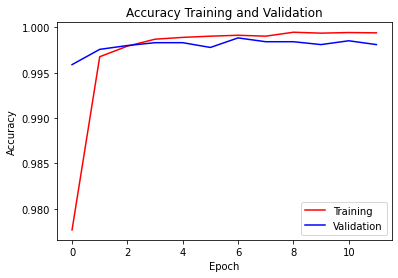

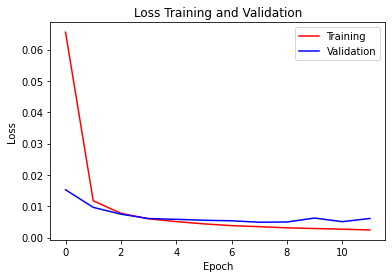

In [15]:
plt.plot(history.history['accuracy'], 'r', label='Training')
plt.plot(history.history['val_accuracy'], 'b', label="Validation")
plt.title('Accuracy Training and Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.show()

plt.plot(history.history['loss'], 'r', label='Training')
plt.plot(history.history['val_loss'], 'b', label="Validation")
plt.title('Loss Training and Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.show()

### This will give us quick metrics on the validation data

In [16]:
loss, accuracy = model.evaluate(valid_data, verbose=1)
print(f'Final validation loss = {loss} accuracy = {round(accuracy * 100, 2)}%')

297/297 [==============================] - 71s 240ms/step - loss: 0.0054 - accuracy: 0.9988
Final validation loss = 0.0053613753989338875 accuracy = 99.88%


<a id="item43"></a>

## Part 2

In this part, you will evaluate your deep learning models on a test data. For this part, you will need to do the following:

1. Load your saved model that was built using the ResNet50 model. 
2. Construct an ImageDataGenerator for the test set. For this ImageDataGenerator instance, you only need to pass the directory of the test images, target size, and the **shuffle** parameter and set it to False.
3. Use the **evaluate_generator** method to evaluate your models on the test data, by passing the above ImageDataGenerator as an argument. You can learn more about **evaluate_generator** [here](https://keras.io/models/sequential/).
4. Print the performance of the classifier using the VGG16 pre-trained model.
5. Print the performance of the classifier using the ResNet pre-trained model.


Use the following cells to evaluate your models.

In [ ]:
vgg16_path = os.path.join(my_path, 'vgg16_model.h5')
vgg16_model = load_model(vgg16_path)

resnet_path = os.path.join(my_path, 'resenet_model.h5')
resent_model = load_model(resenet_path)

<a id="item44"></a>

## Part 3

In this model, you will predict whether the images in the test data are images of cracked concrete or not. You will do the following:

1. Use the **predict_generator** method to predict the class of the images in the test data, by passing the test data ImageDataGenerator instance defined in the previous part as an argument. You can learn more about the **predict_generator** method [here](https://keras.io/models/sequential/).
2. Report the class predictions of the first five images in the test set. You should print something list this:

<center>
    <ul style="list-style-type:none">
        <li>Positive</li>  
        <li>Negative</li> 
        <li>Positive</li>
        <li>Positive</li>
        <li>Negative</li>
    </ul>
</center>

Use the following cells to make your predictions.

### Thank you for completing this lab!

This notebook was created by Alex Aklson.

This notebook is part of a course on **Coursera** called *AI Capstone Project with Deep Learning*. If you accessed this notebook outside the course, you can take this course online by clicking [here](https://cocl.us/DL0321EN_Coursera_Week4_LAB1).

<hr>

Copyright &copy; 2020 [IBM Developer Skills Network](https://cognitiveclass.ai/?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).